In [11]:
import os
print(os.getcwd())
os.chdir(r"C:\VScode\Insurance Coverage Prediction")
print("CWD =", os.getcwd())


C:\VScode\Insurance Coverage Prediction
CWD = C:\VScode\Insurance Coverage Prediction


In [12]:
import pandas as pd
os.chdir(r"C:\VScode\Insurance Coverage Prediction")
os.getcwd()
fe = pd.read_parquet("data/processed/train_last.parquet")
fe_t = pd.read_parquet("data/processed/train_targets.parquet")

In [13]:
print("features :",fe.shape)
print("targets :",fe_t.shape)
print(fe.info())


features : (77607, 61)
targets : (77607, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77607 entries, 0 to 77606
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_ID          77607 non-null  int64  
 1   shopping_pt          77607 non-null  int64  
 2   record_type          77607 non-null  int64  
 3   day                  77607 non-null  int64  
 4   time                 77607 non-null  object 
 5   state                77607 non-null  object 
 6   location             77607 non-null  int64  
 7   group_size           77607 non-null  int64  
 8   homeowner            77607 non-null  int64  
 9   car_age              77607 non-null  int64  
 10  car_value            77607 non-null  object 
 11  risk_factor          77607 non-null  float64
 12  age_oldest           77607 non-null  int64  
 13  age_youngest         77607 non-null  int64  
 14  married_couple       77607 non-null  int64

In [10]:
fe.head()

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,location_enc,car_value_enc,G_enc,state_G_pair,G_sp_pair,state_sp_pair,hash_state_G,hash_location_G,hash_state_sp,hash_G_sp
0,10000000,8,0,0,12:03,IN,10001,2,0,2,...,0,6,0,55,44,179,84333,24616,22620,48487
1,10000005,5,0,3,08:58,NY,10006,1,0,10,...,5,4,1,301,26,411,749,7177,54153,6529
2,10000007,7,0,4,08:43,PA,10008,1,0,11,...,7,2,0,378,35,602,45847,97381,95925,64641
3,10000013,3,0,2,16:36,WV,10014,2,1,3,...,13,3,2,668,18,706,35875,14978,18850,87064
4,10000014,5,0,4,16:43,MO,10015,1,0,5,...,14,3,1,137,26,215,95883,54821,73289,6529


In [14]:
fe_t.head()

,customer_ID,A_f,B_f,C_f,D_f,E_f,F_f,G_f
0,10000000,1,0,2,2,1,2,1
1,10000005,0,0,3,2,0,0,2
2,10000007,0,0,1,2,0,0,1
3,10000013,1,1,3,2,1,1,3
4,10000014,1,1,1,1,0,2,2


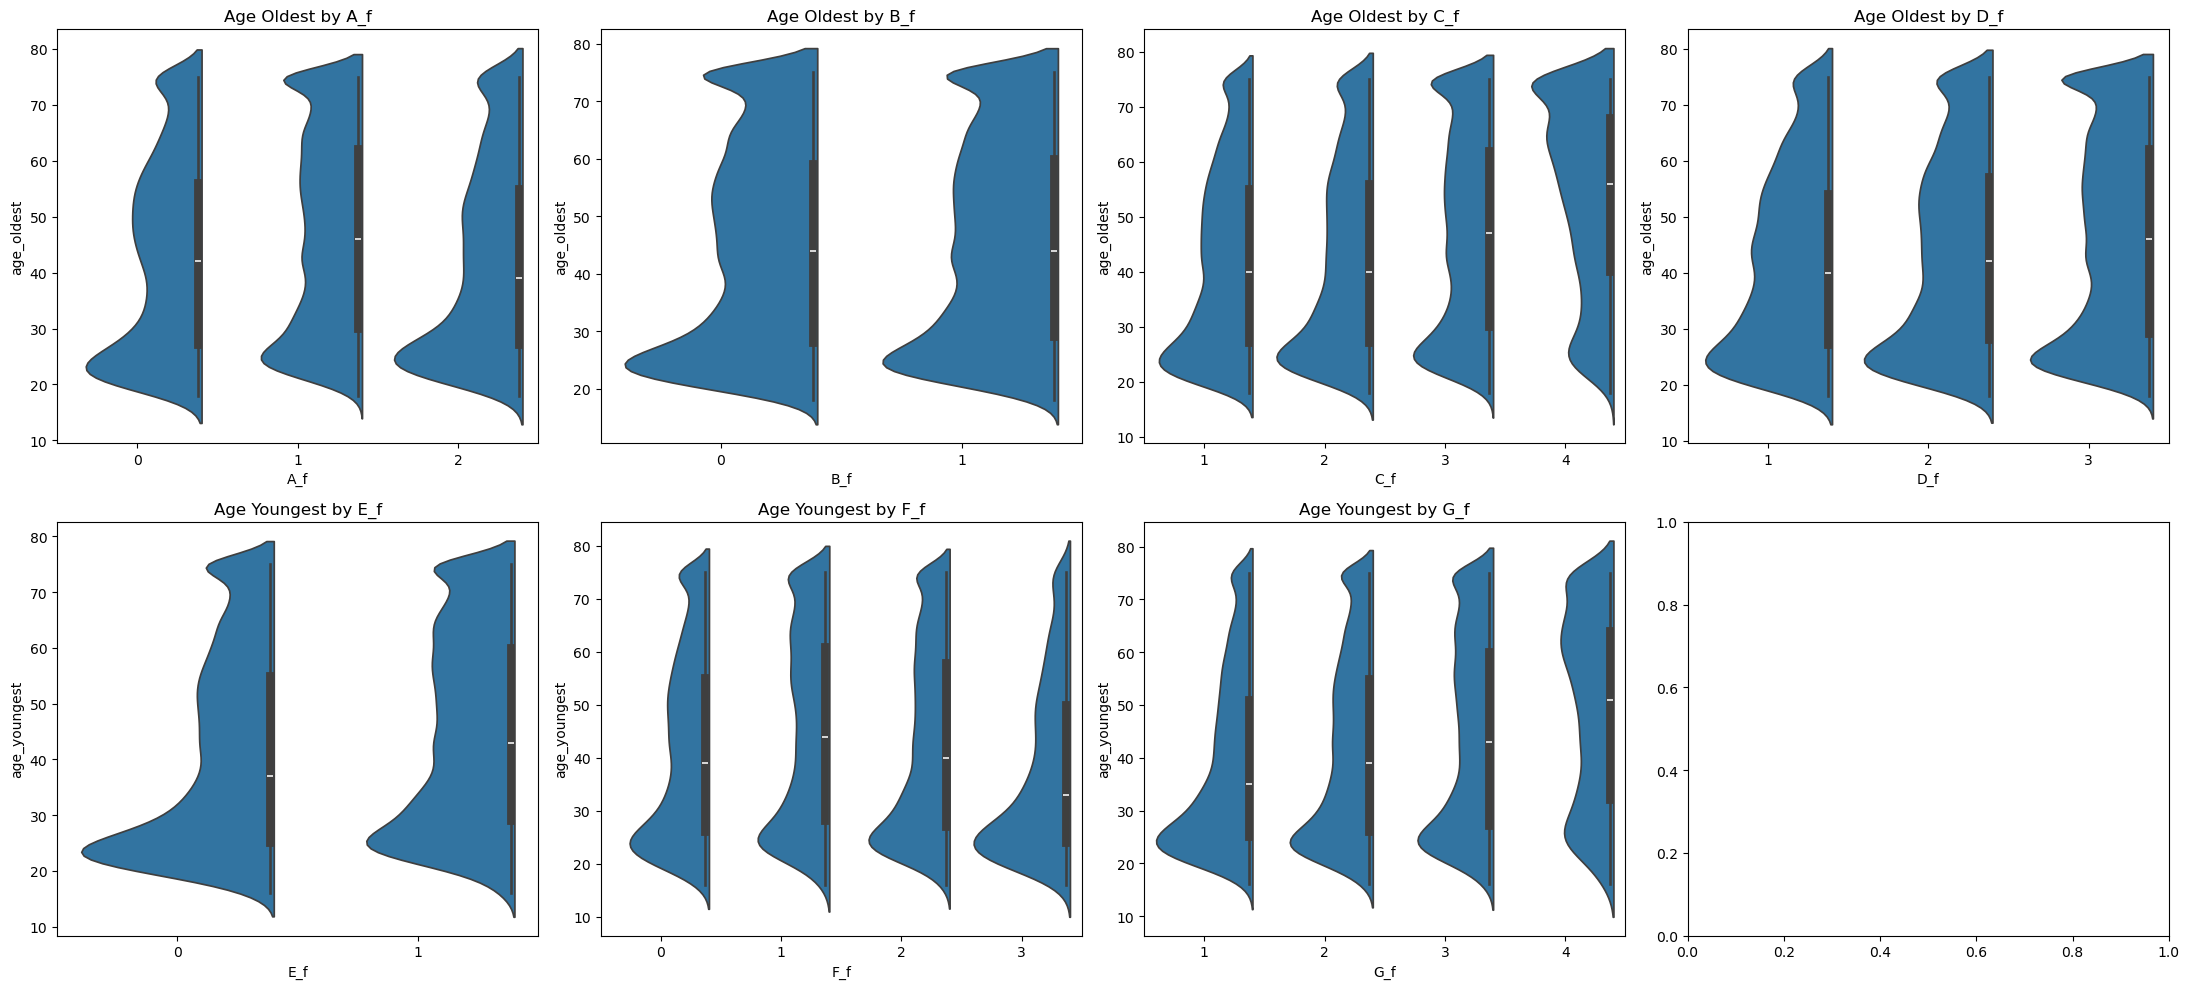

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 4, figsize=(22,10))
opt_cols = ["A_f","B_f","C_f","D_f","E_f","F_f","G_f"]

for i, c in enumerate(opt_cols[:4]):
    sns.violinplot(x=c, y="age_oldest", data=fe, split=True, ax=axes[0][i])
    axes[0][i].set_title(f"Age Oldest by {c}")

for i, c in enumerate(opt_cols[4:]):
    sns.violinplot(x=c, y="age_youngest", data=fe, split=True, ax=axes[1][i])
    axes[1][i].set_title(f"Age Youngest by {c}")

plt.tight_layout()
plt.savefig("analysis/visuals/shopping_pt_dist.png", bbox_inches='tight')


Age patterns are stable across packages

-> age_oldest and age_youngest look almost identical across A–G.

-> No specific age group prefers a particular plan.

-> Age is not a strong differentiator in product choice.

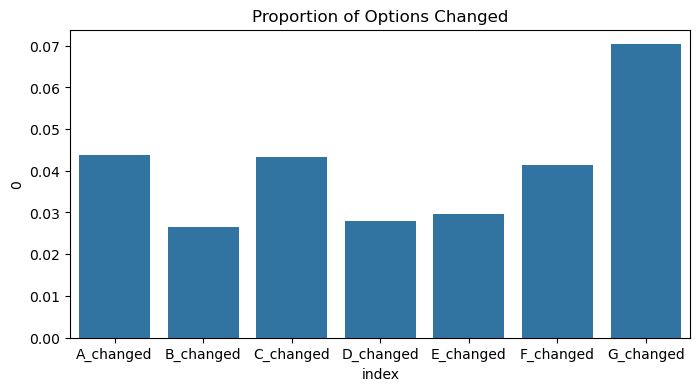

In [16]:
change_cols = [f"{c}_changed" for c in ["A","B","C","D","E","F","G"]]

plt.figure(figsize=(8,4))
sns.barplot(data=fe[change_cols].mean().reset_index(), x="index", y=0)
plt.title("Proportion of Options Changed")
plt.show()


Option changing is uncommon

-> Only 4%–10% customers change a coverage option.

-> Most stick to the first recommendation.

-> Reducing friction early could improve sales.

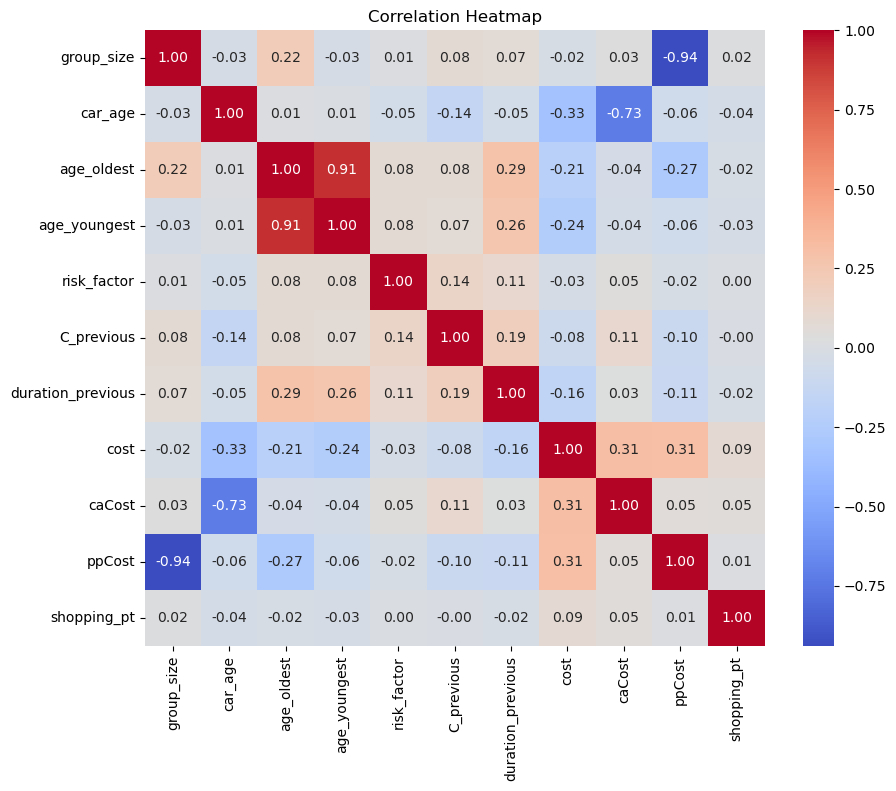

In [17]:
numeric_cols = [
    "group_size","car_age","age_oldest","age_youngest","risk_factor",
    "C_previous","duration_previous","cost","caCost","ppCost","shopping_pt"
]

plt.figure(figsize=(10,8))
sns.heatmap(fe[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig("analysis/visuals/correlation_heatmap.png", bbox_inches='tight')
plt.show()


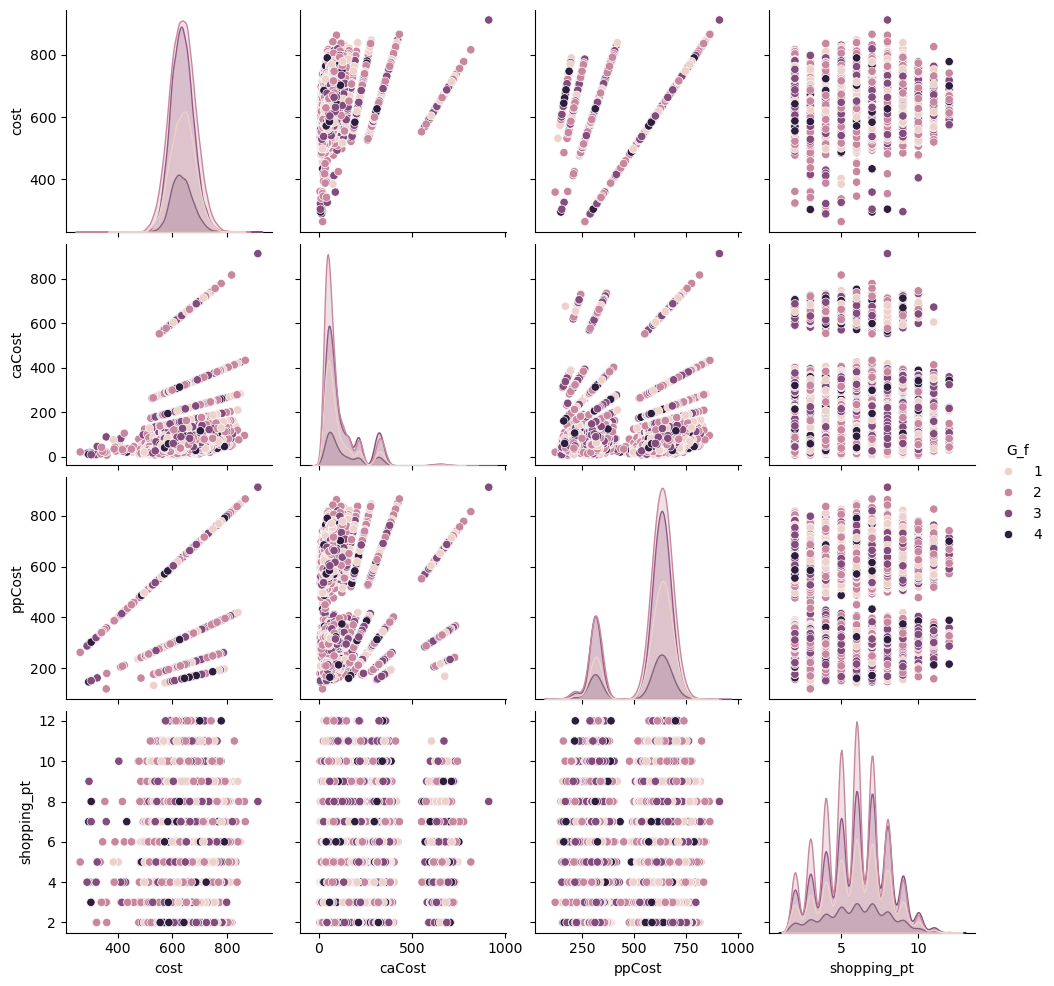

In [18]:
sns.pairplot(fe[["cost","caCost","ppCost","shopping_pt","G_f"]], hue="G_f")
plt.savefig("pairplot.png")
plt.savefig("analysis/visuals/pairplot.png", bbox_inches='tight')
plt.show()


Cost-engineered features are meaningful

-> ppCost (cost per person) and caCost (cost per car age) show strong structure.

-> ppCost has a strong negative correlation with cost — expected:

-> Larger family → lower per-person premium.

-> These engineered features help the model understand pricing fairness.

In [19]:
import pandas as pd
from src.config import FEATURE_COLS


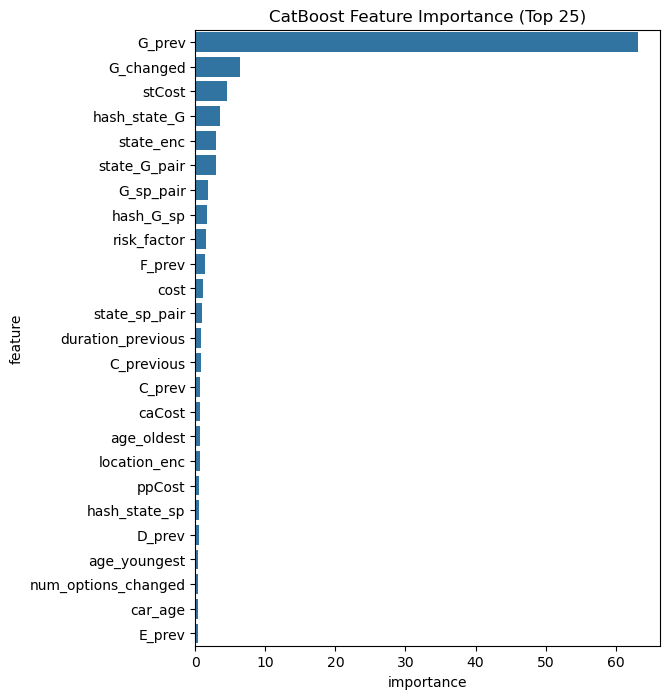

In [20]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0)
model.fit(fe[FEATURE_COLS], fe["G_f"])

imp = pd.DataFrame({
    "feature": FEATURE_COLS,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x="importance", y="feature", data=imp.head(25))
plt.title("CatBoost Feature Importance (Top 25)")
plt.savefig("analysis/visuals/feature_importance.png", bbox_inches='tight')
plt.show()


The final chosen option depends heavily on the previous quote

-> G_prev is by far the most important feature in CatBoost.

-> If someone selected option G earlier, they usually stick to G later.

-> Same logic applies to A, B, C, etc.

-> Customers are creatures of habit — they rarely change choices.

Feature Importance tells a clear story

-> Top predictive signals:

    1.Previous choice

    2.Whether the customer changed options

    3.State-based pricing

    4.Encoded geography

    5.Shopping point

    6.Risk factor

  Customer behavior > demographics.

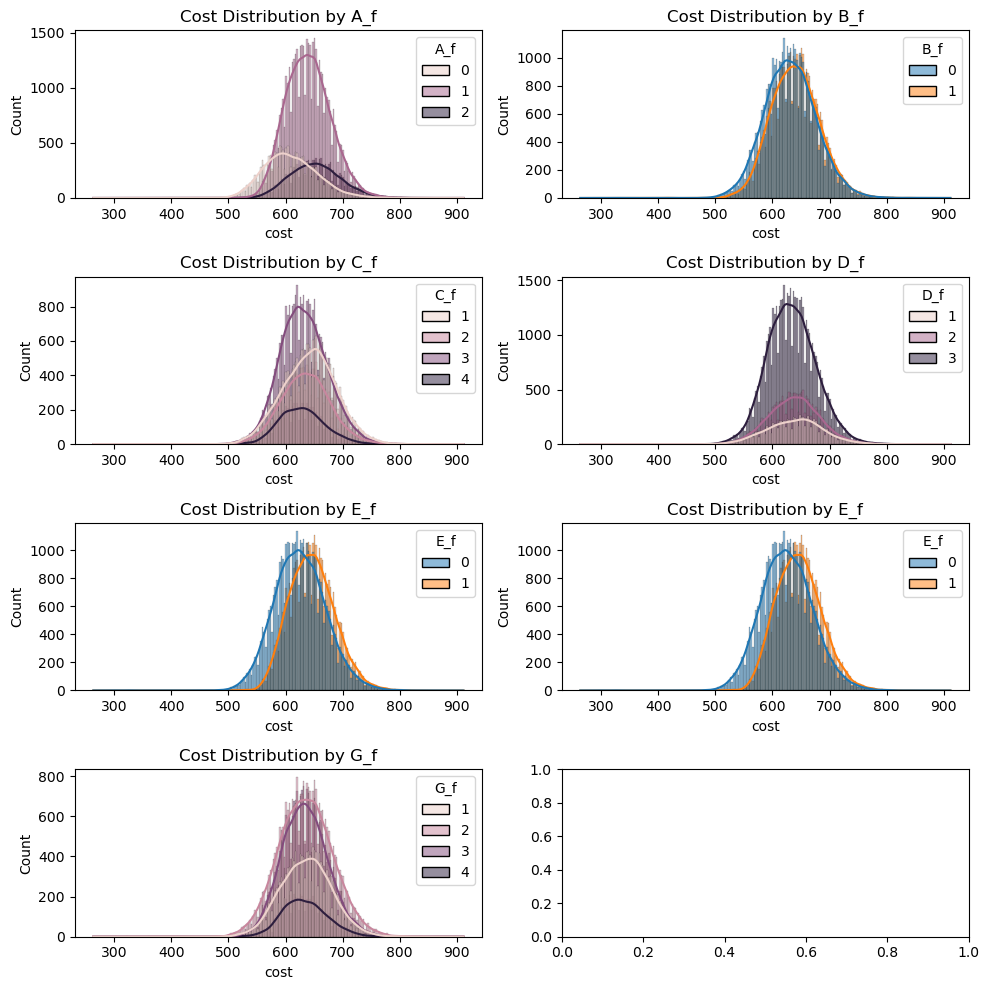

In [21]:

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

targets = ["A_f", "B_f", "C_f", "D_f", "E_f", "E_f", "G_f"]

for i, t in enumerate(targets):
    r = i//2
    c = i%2
    sns.histplot(data=fe, x="cost", hue=t, kde=True, ax=axes[r][c])
    axes[r][c].set_title(f"Cost Distribution by {t}")

plt.tight_layout()
plt.savefig("analysis/visuals/cost_target.png", bbox_inches='tight')
plt.show()

Insurance cost is mostly similar

-> Most customers’ insurance cost lies between ₹550–₹750.

-> Across A–G final choices, the cost curve looks very similar.

-> Meaning price alone doesn’t decide which plan a customer finally buys.

-> In features B_f and G_f some target point having same cost distribution which may lead to poor classification.